In [6]:
# -*- coding: utf-8 -*-
# importing libraries
import matplotlib 
matplotlib.use('Agg')
from scipy import misc
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import ticker
from mpl_toolkits.basemap import Basemap, addcyclic, shiftgrid
from pylab import *
# Important to download matlab files
import scipy.io
from numpy import linspace
from numpy import meshgrid
import numpy.ma as madd

import netCDF4
from netCDF4 import Dataset

import codes
from codes import *

%matplotlib inline

In [7]:
def importNetcdf(path,variable_name):
    nc_fid = Dataset(path, 'r')
    field = nc_fid.variables[variable_name][:]     
    return field 

In [8]:
bins_Lon = np.arange(-180,180,0.5)
bins_Lat = np.arange(-90,90,0.5)

In [9]:
# Path to cloud data in the EP
path = '/Users/fabrizio/Dropbox/PHD/Phd/Project/LowCloudCover_and_DC/Main_analysis/analysis/DimReduction_EP_Atl/data/EP_region_of_interest.nc'

In [45]:
# Path to enviromental variables
# temp
path_T = '/Users/fabrizio/Dropbox/PHD/Phd/Project/LowCloudCover_and_DC/Codes/ERA5/t2m_daymean_tropics_2008_EP_big.nc'
# Surface Evaporation
path_SE = '/Users/fabrizio/Dropbox/PHD/Phd/Project/LowCloudCover_and_DC/Codes/ERA5/evap_daymean_tropics_2008_EP_big.nc'
# Vertical Velocity
path_V_1000 = '/Users/fabrizio/Dropbox/PHD/Phd/Project/LowCloudCover_and_DC/Codes/ERA5/w_daymean_tropics_2008_EP_big_1000hPa.nc'
path_V_500 = '/Users/fabrizio/Dropbox/PHD/Phd/Project/LowCloudCover_and_DC/Codes/ERA5/w_daymean_tropics_2008_EP_big_500hPa.nc'
path_V_200 = '/Users/fabrizio/Dropbox/PHD/Phd/Project/LowCloudCover_and_DC/Codes/ERA5/w_daymean_tropics_2008_EP_big_200hPa.nc'

In [69]:
# Import clouds
year_Ci_masked = importNetcdf(path,'class1') # Cirrus clouds
year_St_masked = importNetcdf(path,'class4') # Stratus clouds
year_Sc_masked = importNetcdf(path,'class5') # Stratocumulus clouds
year_Cu_masked = importNetcdf(path,'class6') # Cumulus clouds
year_Dc_masked = importNetcdf(path,'class8') # DC clouds
# Import environment
year_t_masked = importNetcdf(path_T,'t2m') # t at 2 meter
year_e_masked = importNetcdf(path_SE,'e') # surface evap
year_v_1000_masked = importNetcdf(path_V_1000,'w') # v at 1000 hPa
year_v_500_masked = importNetcdf(path_V_500,'w') # v at 500 hPa
year_v_200_masked = importNetcdf(path_V_200,'w') # v at 200 hPa

In [93]:
test = year_t_masked[:,1:,1:]

In [70]:
lon = importNetcdf(path,'lon')# longitude
lat = importNetcdf(path,'lat')# latitude

In [150]:
lon_1 = importNetcdf(path_T,'longitude')# longitude
lat_1 = importNetcdf(path_T,'latitude')# latitude

In [71]:
np.shape(year_Sc_masked)

(366, 90, 120)

In [94]:
np.shape(test)

(366, 90, 120)

In [72]:
# There are many NaNs here.
# For each time series I do the following:
# If the number of NaNs is <= 50% than I compute the average only with the numbers
# If the number of NaNs is > 50% than I compute the average after substituting 0s to all NaNs

# First thing I need for this is the percentage of NaNs
# I want to compute the percentage of NaN values
# I just need 1 class for this: I choose class 0
# Then for each grid point I simply count the nan values
# Occurrences for a matrix (with NaNs) of dimension [time, lat, lon]
def occurrenceOfNaNs(field):
    
    shape = np.shape(field)
    dimT = shape[0]
    dimY = shape[1]
    dimX = shape[2]
    
    # Initialize the average
    occ = np.zeros([dimY, dimX])
    
    for y in range(dimY):
        for x in range(dimX):
            occ[y,x] = sum(np.isnan(field[:,y,x]))/366.
            
    return occ  

occ_of_NaNs = occurrenceOfNaNs(year_Sc_masked[:,:,:])

In [73]:
np.savetxt('occurrence_of_NaNs_Tropics.txt',occ_of_NaNs, fmt = '%1.6f')

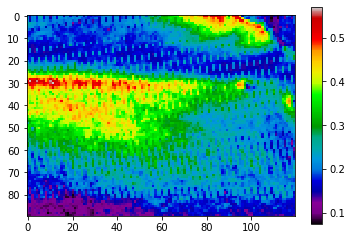

In [74]:
plt.imshow(np.flipud(occ_of_NaNs),cmap=plt.cm.nipy_spectral);colorbar()

In [75]:
mask = occ_of_NaNs.copy()

In [76]:
# If a grid point is a nan more than 70% of the time we want it to be always masked
mask[mask>=0.7] = np.nan

In [77]:
# In "mask", points that are not masked go to zero (I know, amazing)
mask[~np.isnan(mask)]=0

In [78]:
# Do not work with masked array
# Here I convert it to normal arrays
def convert_to_array(data):
    return np.ma.filled(data.astype(float), np.nan)
    
year_Ci = convert_to_array(year_Ci_masked)
year_St = convert_to_array(year_St_masked)
year_Sc = convert_to_array(year_Sc_masked)
year_Cu = convert_to_array(year_Cu_masked)
year_Dc = convert_to_array(year_Dc_masked)
year_t = convert_to_array(year_t_masked)
year_e = convert_to_array(year_e_masked)
year_v_1000 = convert_to_array(year_v_1000_masked)
year_v_500 = convert_to_array(year_v_500_masked) 
year_v_200 = convert_to_array(year_v_200_masked) 

In [79]:
# Mask the field with the mask
year_Ci_masked = year_Ci + mask
year_St_masked = year_St + mask
year_Sc_masked = year_Sc + mask
year_Cu_masked = year_Cu + mask
year_Dc_masked = year_Dc + mask

In [80]:
# We combine Stratocumulus and stratus clouds
low_clouds = (year_St_masked + year_Sc_masked)/2

In [81]:
# Now we consider only time series are not masked by mask
# For those points we remove NaNs by linear interpolation

# Function for linear interpolation
# From this gentle contributor:
# https://stackoverflow.com/questions/6518811/interpolate-nan-values-in-a-numpy-array

def nan_helper(y):
    """Helper to handle indices and logical indices of NaNs.

    Input:
        - y, 1d numpy array with possible NaNs
    Output:
        - nans, logical indices of NaNs
        - index, a function, with signature indices= index(logical_indices),
          to convert logical indices of NaNs to 'equivalent' indices
    Example:
        >>> # linear interpolation of NaNs
        >>> nans, x= nan_helper(y)
        >>> y[nans]= np.interp(x(nans), x(~nans), y[~nans])
    """

    return np.isnan(y), lambda z: z.nonzero()[0]

def remove_nans(y):
    
    new_y = y.copy()
    nans, x= nan_helper(new_y)
    new_y[nans]= np.interp(x(nans), x(~nans), new_y[~nans])
    
    return new_y

# Given a 2+1 dimensional field, mask the grid points with more 70% of nans values
# for the remaining grid points remove the nans.
def remove_nans_field(x_field):
    # Input: x is a field. np.shape(x) = [time, lat, lon]
    # Output: a field y, np.shape(y) = [time, lat, lon]. y contains
    # detrended anomalies, normalized to zero mean and unit variance
    # in each grid point (i,j)

    # shape
    shape_field = np.shape(x_field)
    dim_t = shape_field[0]
    dim_lat = shape_field[1]
    dim_lon = shape_field[2]

    # Initialize the new field
    y_field = np.zeros([dim_t,dim_lat,dim_lon])

    for i in range(dim_lat):
        for j in range(dim_lon):
            # If is a masked fucker then leave it be
            if ~np.isnan(mask[i,j]):
                y_field[:,i,j] = remove_nans(x_field[:,i,j])
            else:
                # Just cook up a time series of just nans
                spuff = np.arange(dim_t, dtype=int)
                all_nans = np.full_like(spuff, np.nan, dtype=np.double)
                y_field[:,i,j] = all_nans

    return y_field

In [106]:
def anomalies_field(x):
    # Input: x is a field. np.shape(x) = [time, lat, lon]
    # Output: a field y, np.shape(y) = [time, lat, lon]. y contains
    # detrended anomalies, normalized to zero mean and unit variance
    # in each grid point (i,j)

    # shape
    shape_field = np.shape(x)
    dim_t = shape_field[0]
    dim_lat = shape_field[1]
    dim_lon = shape_field[2]

    # Initialize the new field
    y = np.zeros([dim_t,dim_lat,dim_lon])

    for i in range(dim_lat):
        for j in range(dim_lon):
            # remove only if it is not masked
            if ~np.isnan(x[0,i,j]):
                # remove a trend
                x_detrended = signal.detrend(x[:,i,j])
                # remove the seasonal cycle
                x_anomalies = codes.anomalies(x_detrended)
                y[:,i,j] = x_anomalies
            else:
                # Just cook up a time series of just nans
                spuff = np.arange(dim_t, dtype=int)
                all_nans = np.full_like(spuff, np.nan, dtype=np.double)
                y[:,i,j] = all_nans
    
    # last check: be sure that if a time series is nan at time t it will be nan for all t
    for i in range(dim_lat):
        for j in range(dim_lon):
            for t in range(dim_t):
                if np.isnan(y[t,i,j]):
                    y[:,i,j] = np.nan
                                        

    return y

In [107]:
year_Ci_masked_ip = remove_nans_field(year_Ci_masked)
year_LowClouds_masked_ip = remove_nans_field(low_clouds)
year_Cu_masked_ip = remove_nans_field(year_Cu_masked)
year_Dc_masked_ip = remove_nans_field(year_Dc_masked)

In [108]:
# Cool. Now compute the anomalies

In [109]:
# Compute the anomalies of clouds
year_Ci_a = anomalies_field(year_Ci_masked_ip)
year_LowClouds_a = anomalies_field(year_LowClouds_masked_ip)
year_Cu_a = anomalies_field(year_Cu_masked_ip)
year_Dc_a = anomalies_field(year_Dc_masked_ip)

In [115]:
# Compute the anomalies of the enviromental variables
year_t_a = anomalies_field(year_t)
year_se_a = anomalies_field(year_e)
year_w_1000_a = anomalies_field(year_v_1000[:,0,:,:])
year_w_500_a = anomalies_field(year_v_500[:,0,:,:])
year_w_200_a = anomalies_field(year_v_200[:,0,:,:])

In [116]:
np.save('/Users/fabrizio/Dropbox/PHD/Phd/Project/LowCloudCover_and_DC/Main_analysis/analysis/DimReduction_EP_Atl/preProcess_py/preprocessed_data/Ci_a.npy',year_Ci_a)
np.save('/Users/fabrizio/Dropbox/PHD/Phd/Project/LowCloudCover_and_DC/Main_analysis/analysis/DimReduction_EP_Atl/preProcess_py/preprocessed_data/lowClouds_a.npy',year_LowClouds_a)
np.save('/Users/fabrizio/Dropbox/PHD/Phd/Project/LowCloudCover_and_DC/Main_analysis/analysis/DimReduction_EP_Atl/preProcess_py/preprocessed_data/Cu_a.npy',year_Cu_a)
np.save('/Users/fabrizio/Dropbox/PHD/Phd/Project/LowCloudCover_and_DC/Main_analysis/analysis/DimReduction_EP_Atl/preProcess_py/preprocessed_data/Dc_a.npy',year_Dc_a)

np.save('/Users/fabrizio/Dropbox/PHD/Phd/Project/LowCloudCover_and_DC/Main_analysis/analysis/DimReduction_EP_Atl/preProcess_py/preprocessed_data/t2m_a.npy',year_t_a)
np.save('/Users/fabrizio/Dropbox/PHD/Phd/Project/LowCloudCover_and_DC/Main_analysis/analysis/DimReduction_EP_Atl/preProcess_py/preprocessed_data/se_a.npy',year_se_a)
np.save('/Users/fabrizio/Dropbox/PHD/Phd/Project/LowCloudCover_and_DC/Main_analysis/analysis/DimReduction_EP_Atl/preProcess_py/preprocessed_data/w_1000_a.npy',year_w_1000_a)
np.save('/Users/fabrizio/Dropbox/PHD/Phd/Project/LowCloudCover_and_DC/Main_analysis/analysis/DimReduction_EP_Atl/preProcess_py/preprocessed_data/w_500_a.npy',year_w_500_a)
np.save('/Users/fabrizio/Dropbox/PHD/Phd/Project/LowCloudCover_and_DC/Main_analysis/analysis/DimReduction_EP_Atl/preProcess_py/preprocessed_data/w_200_a.npy',year_w_200_a)

In [122]:
# Compute the std: clouds
year_Ci_a_std = np.std(year_Ci_a,axis=0)
year_LowClouds_a_std = np.std(year_LowClouds_a,axis = 0)
year_Cu_a_std = np.std(year_Cu_a,axis = 0)
year_Dc_a_std = np.std(year_Dc_a,axis = 0)

In [123]:
# Compute the std: environment
year_t_a_std = np.std(year_t,axis = 0)
year_e_a_std = np.std(year_e,axis = 0)
year_w_1000_a_std =  np.std(year_w_1000_a,axis = 0)
year_w_500_a_std = np.std(year_w_500_a,axis = 0)
year_w_200_a_std = np.std(year_w_200_a,axis = 0)

In [161]:
def plotField(field, title, savingTitle):
    
    #max_value = np.max(field)

    fig = plt.figure()
    ax = fig.add_axes([0,0,2,2])    
        
    map = Basemap(projection='cyl',
                llcrnrlat=-30,urcrnrlat=15,\
                llcrnrlon=-140,urcrnrlon=-80)
    map.drawcoastlines()
    map.drawparallels(np.arange(-30.,20.,10.), \
              labels=[1,0,0,0],fontsize = 20)
    map.drawmeridians(np.arange(-180.,180.,30.), \
              labels=[0,0,0,1],fontsize = 20)
    #map.fillcontinents(color = 'black')
    
    #cmap=discrete_cmap(50,base_cmap=plt.cm.jet)
    map.pcolor(lon,lat,field,cmap=plt.cm.viridis)
    map.drawcoastlines()

    #ticks = [100000,200000,300000,400000,500000,600000,700000],
    #cb=plt.colorbar(ticks = [0,0.2,0.4,0.6,0.8,1],location='bottom',aspect=30,pad=0.08)
    cb=plt.colorbar(location='bottom',aspect=30,pad=0.08)
    #cb.ax.set_xticklabels(['0','0.2','0.4','0.6','0.8','1'])
    #cb.ax.text(0.5, 0.5, r'$\times$10$^{5}$',va='bottom', ha='right',size = 25)
    font_size = 20 # Adjust as appropriate. va='bottom', ha='right'
    cb.ax.tick_params(labelsize=25)

    plt.title(title, fontsize = 30)

    savefig(savingTitle, bbox_inches='tight')

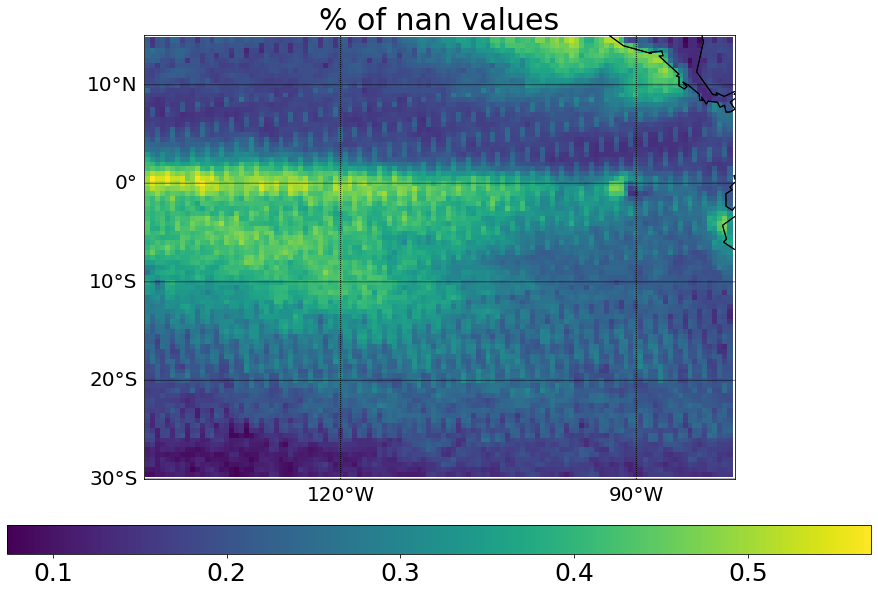

In [162]:
plotField(occ_of_NaNs, '% of nan values', 'nan_percentage.png')

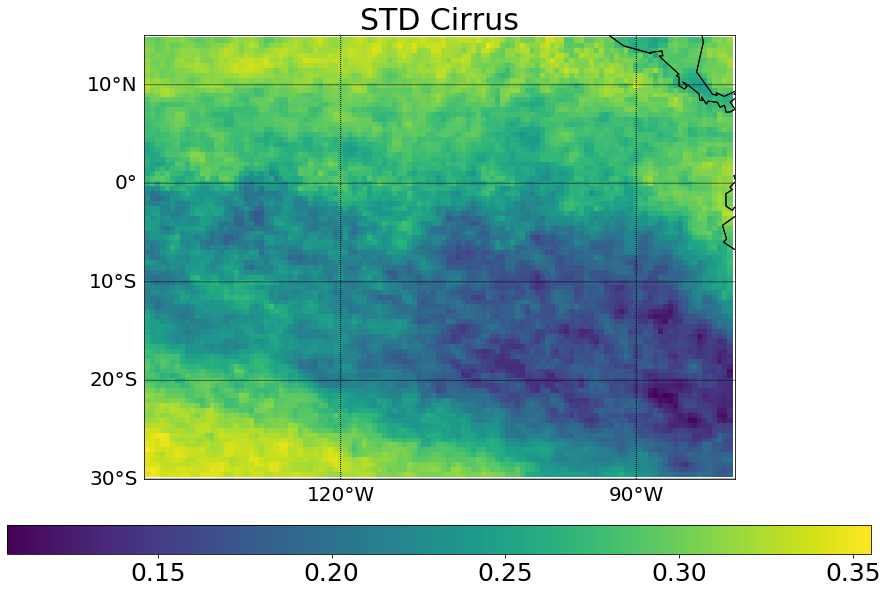

In [142]:
plotField(year_Ci_a_std, 'STD Cirrus', 'STD_Ci.png')

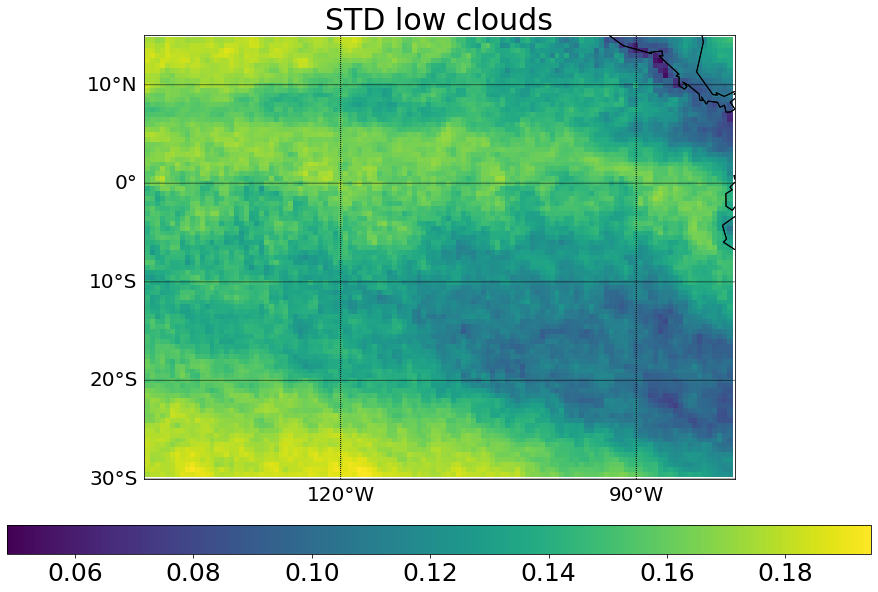

In [143]:
plotField(year_LowClouds_a_std, 'STD low clouds', 'STD_LowClouds.png')

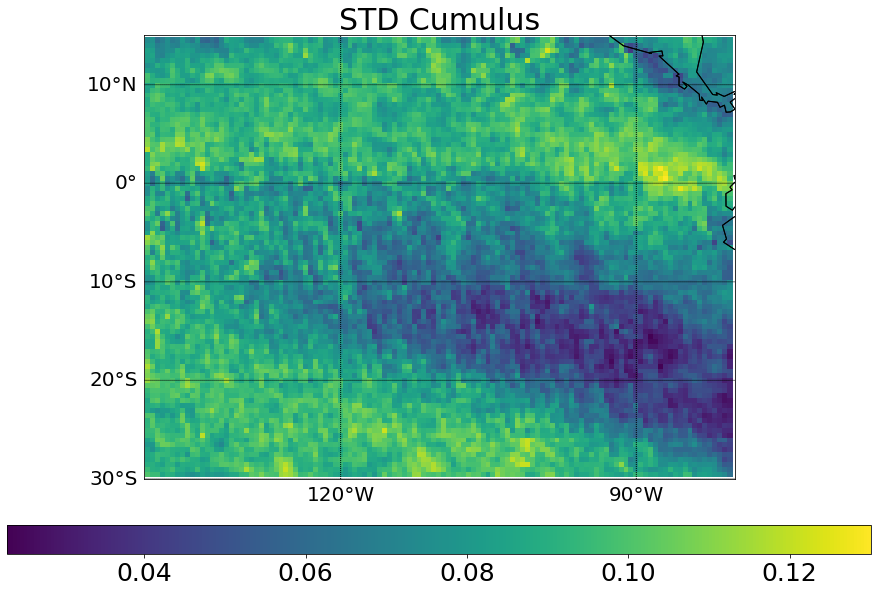

In [144]:
plotField(year_Cu_a_std, 'STD Cumulus', 'STD_Cu.png')

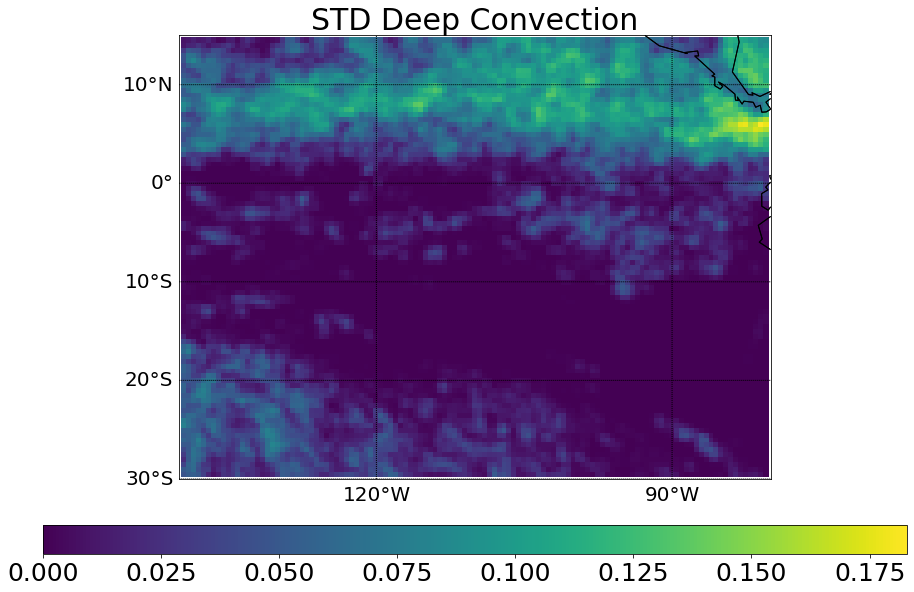

In [145]:
plotField(year_Dc_a_std, 'STD Deep Convection', 'STD_Dc.png')

In [147]:
# When plotting the enviromental data remember to change lon and lat to lon_1 and lat_1
# the enviromental guys have 1 more point in both latitude and longitude

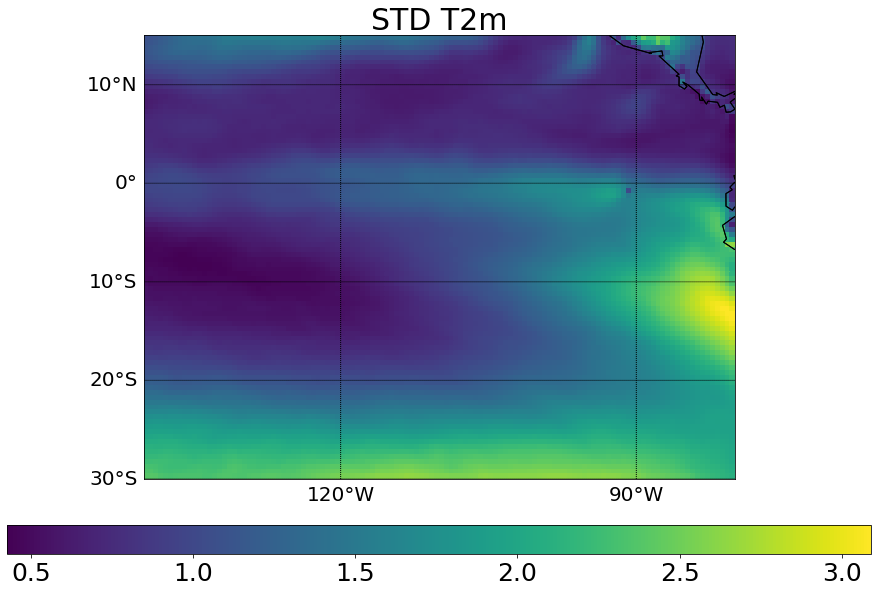

In [152]:
plotField(year_t_a_std, 'STD T2m', 'STD_T2m.png')

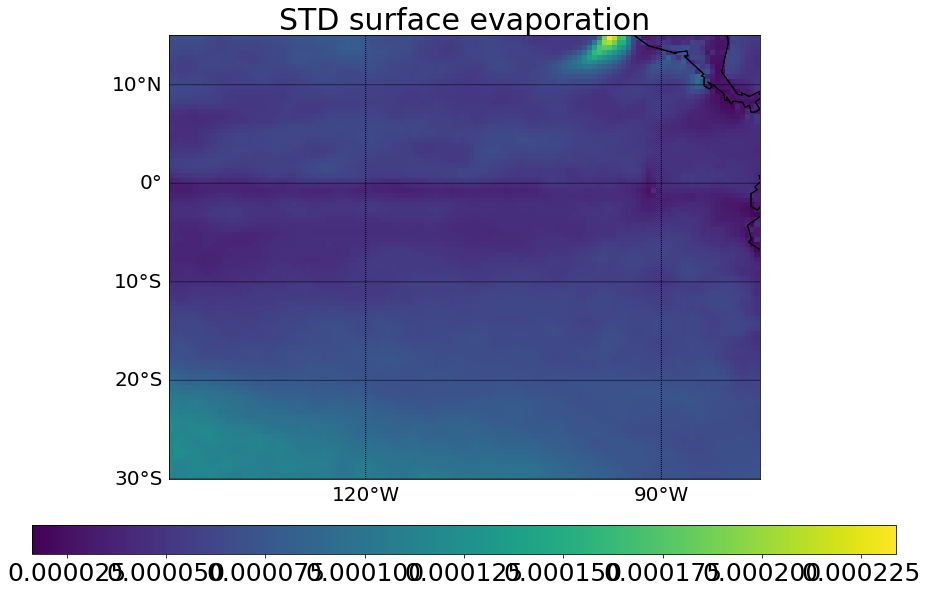

In [153]:
plotField(year_e_a_std, 'STD surface evaporation', 'STD_SE.png')

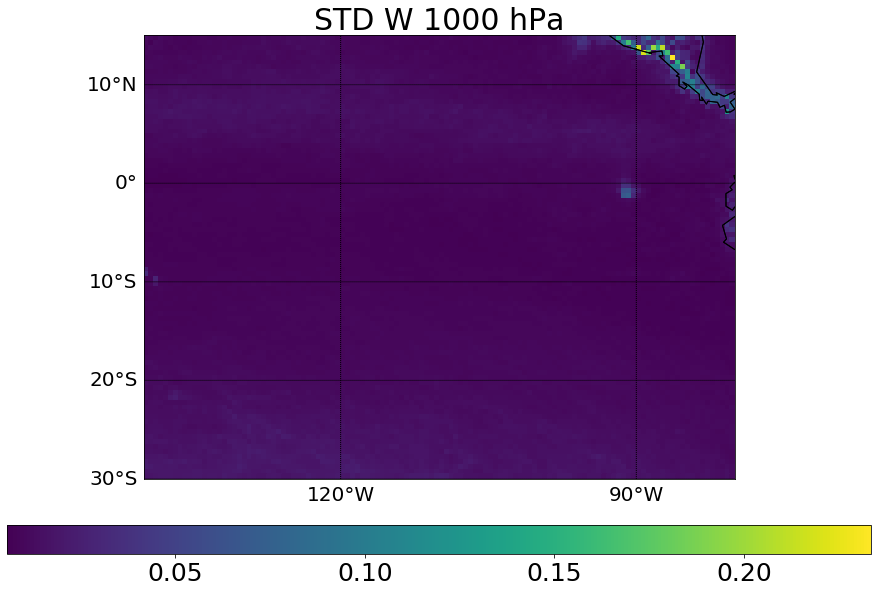

In [154]:
plotField(year_w_1000_a_std, 'STD W 1000 hPa', 'STD_W_1000hPa.png')

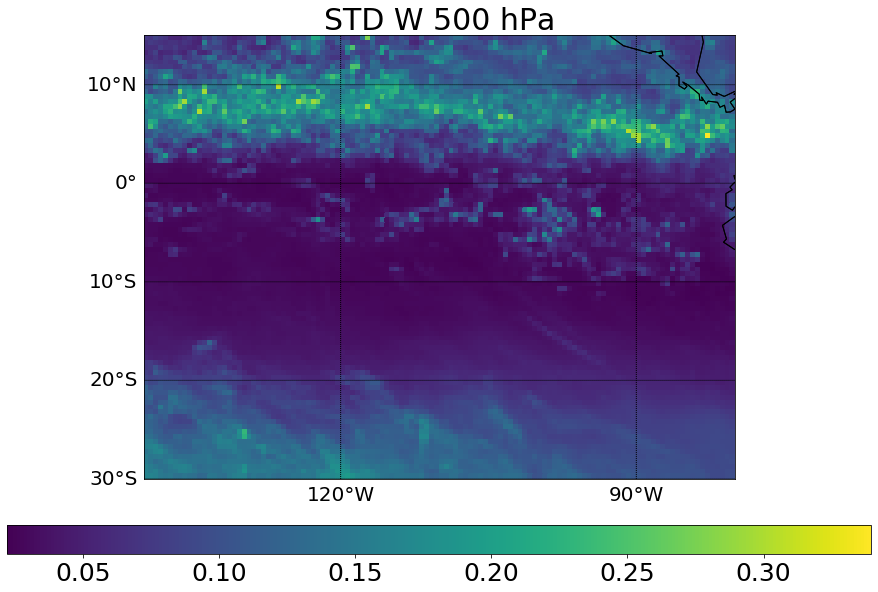

In [155]:
plotField(year_w_500_a_std, 'STD W 500 hPa', 'STD_W_500hPa.png')

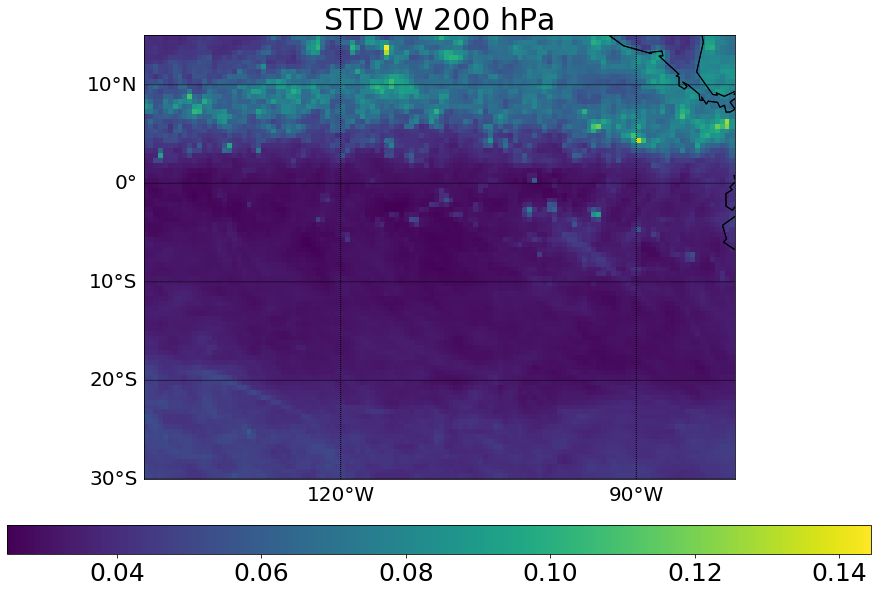

In [156]:
plotField(year_w_200_a_std, 'STD W 200 hPa', 'STD_W_200hPa.png')

In [198]:
# Let's look also at the occurrences
occurrence_Ci = np.nanmean(year_Ci_masked_ip, axis = 0)
occurrence_LowClouds = np.nanmean(year_LowClouds_masked_ip,axis = 0)
occurrence_Cu = np.nanmean(year_Cu_masked_ip,axis = 0)
occurrence_Dc = np.nanmean(year_Dc_masked_ip,axis = 0)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: Mean of empty slice
  
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: Mean of empty slice
  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: Mean of empty slice
  after removing the cwd from sys.path.
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: Mean of empty slice
  """


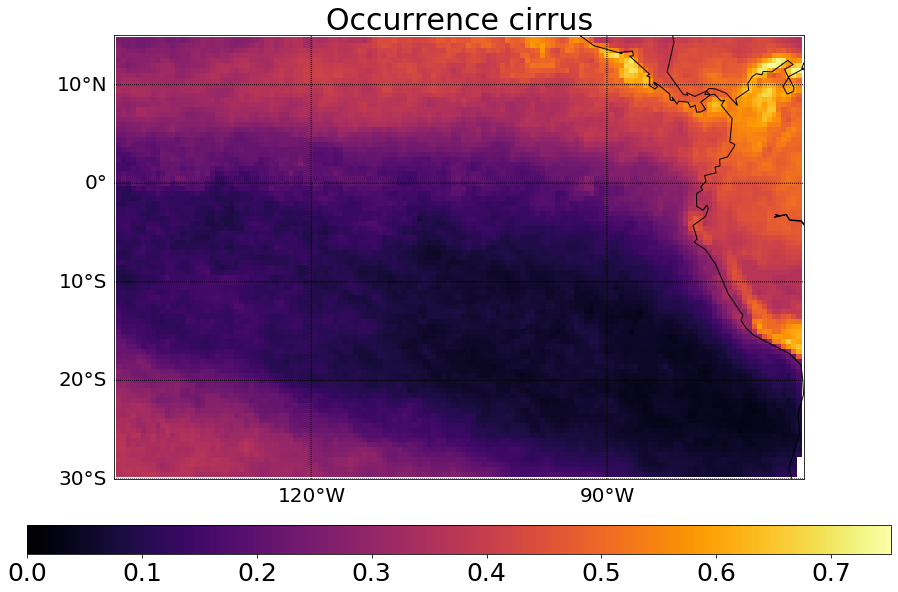

In [115]:
plotField(occurrence_Ci, 'Occurrence cirrus', 'Ci_occ.png')

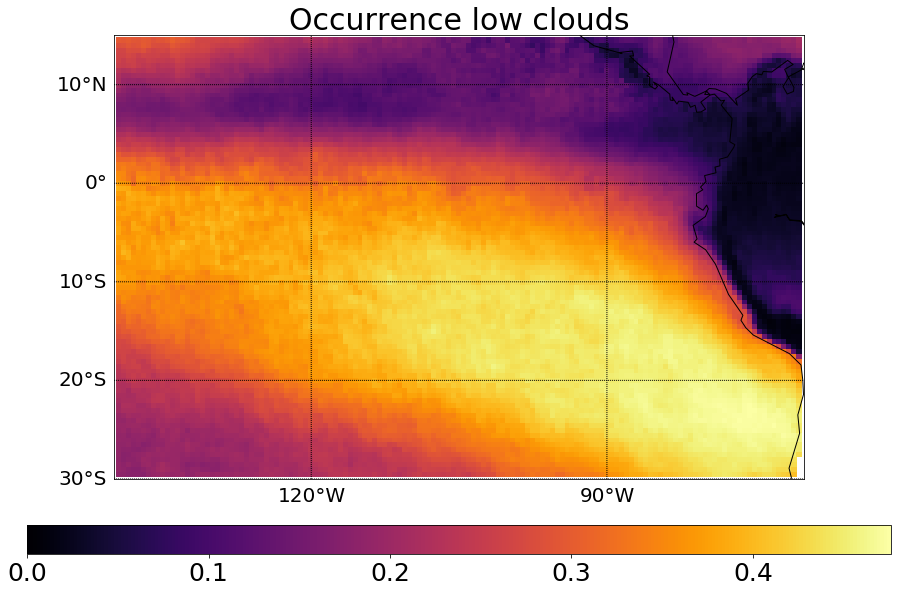

In [114]:
plotField(occurrence_LowClouds, 'Occurrence low clouds', 'lowClouds_occ.png')

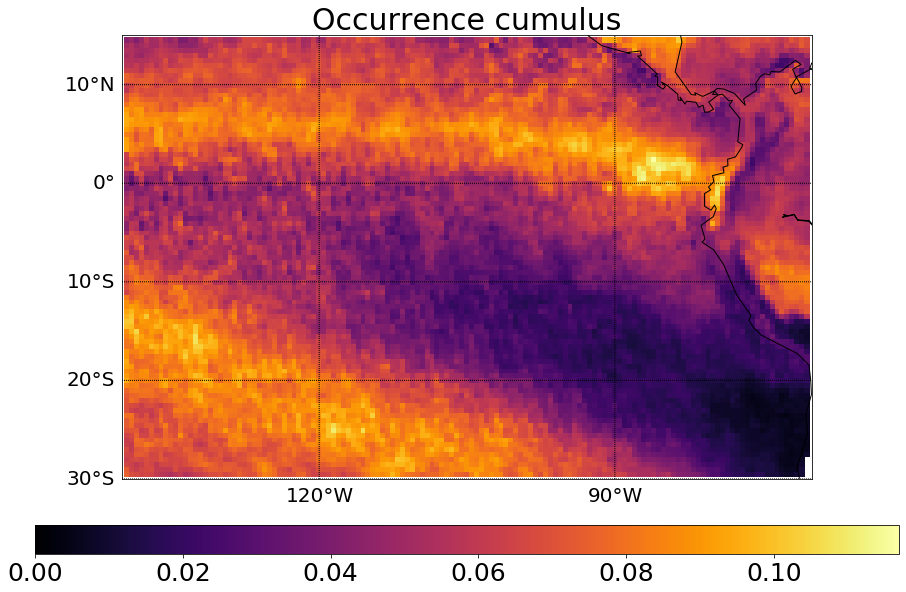

In [145]:
plotField(occurrence_Cu, 'Occurrence cumulus', 'Cu_occ.png')

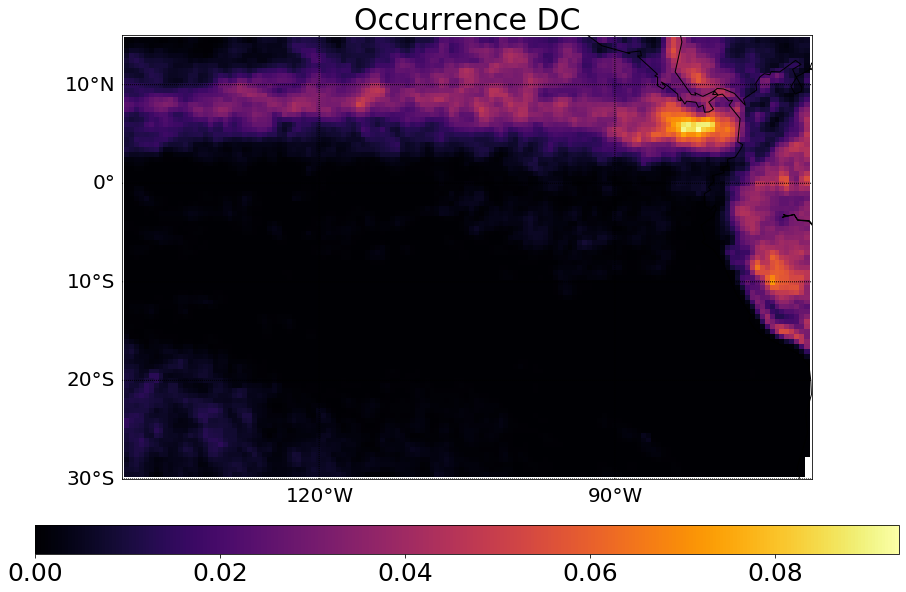

In [200]:
plotField(occurrence_Dc, 'Occurrence DC', 'DC_occ.png')